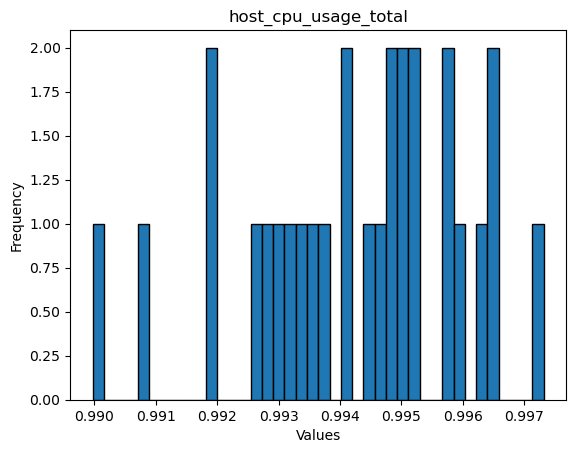

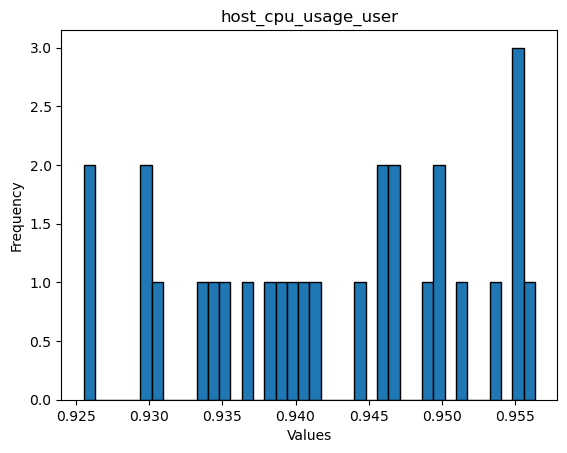

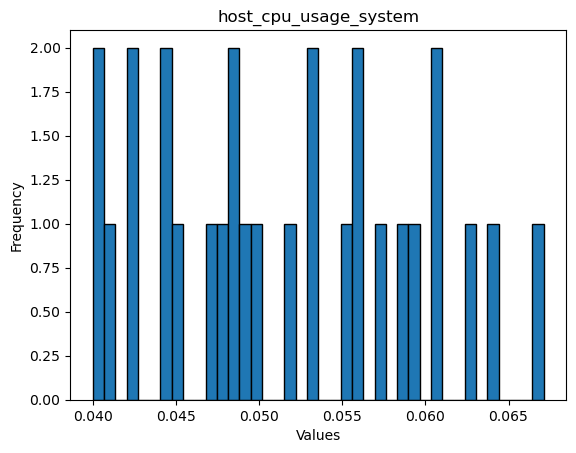

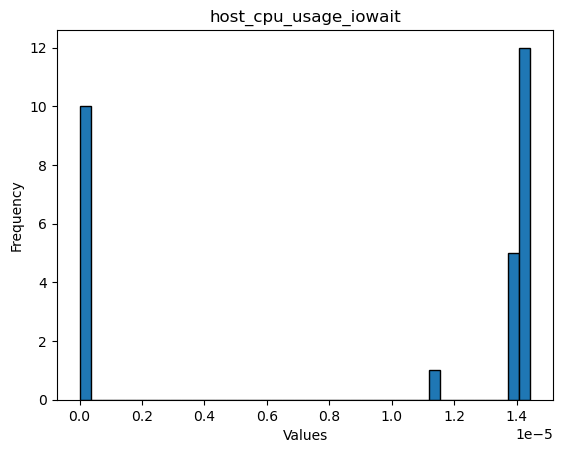

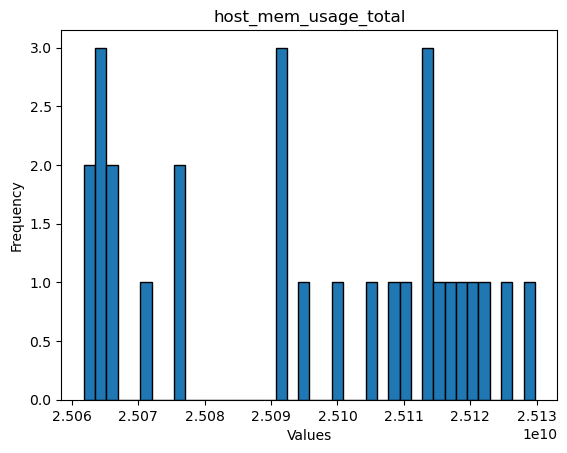

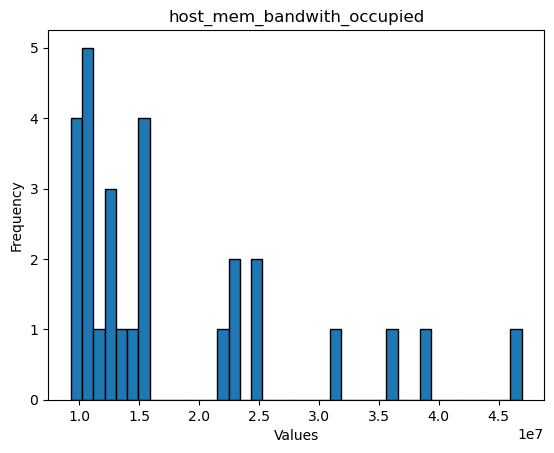

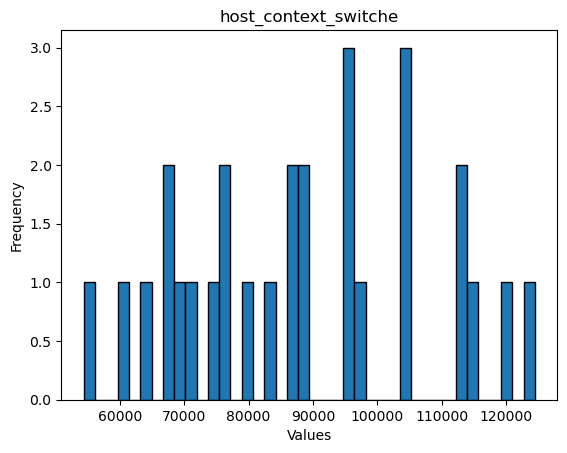

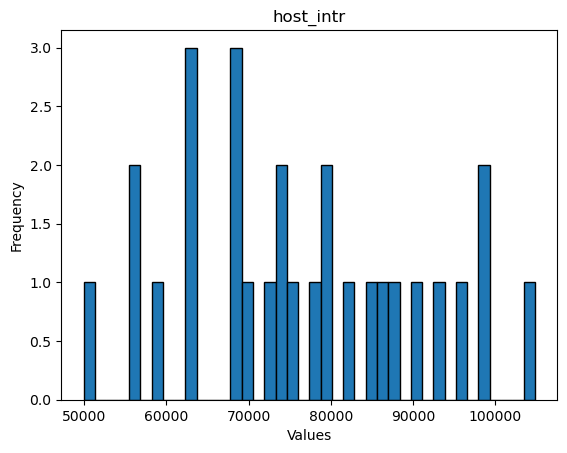

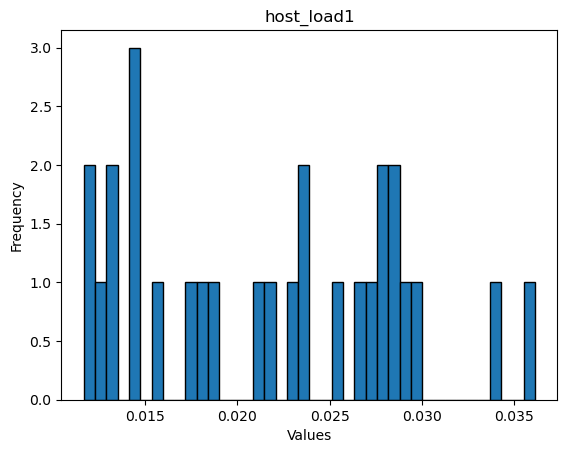

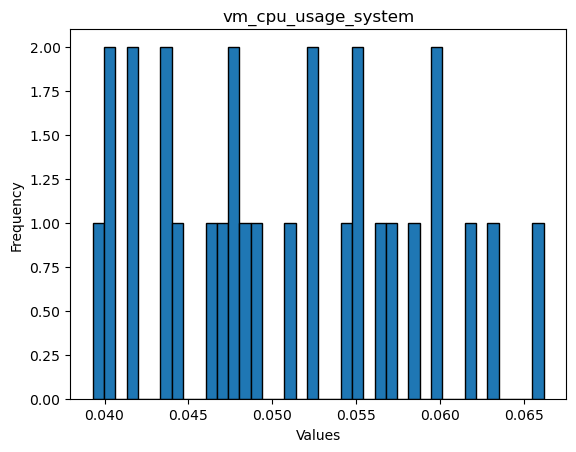

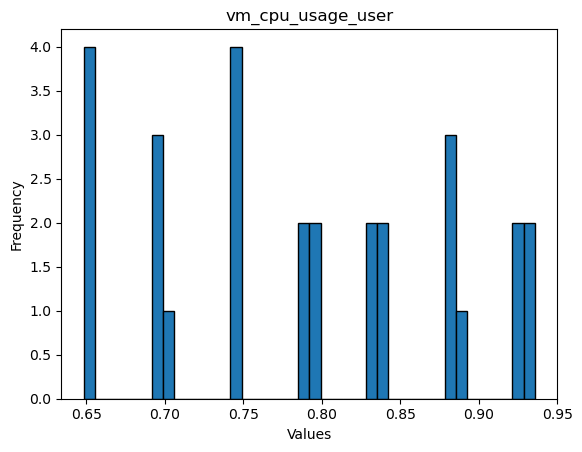

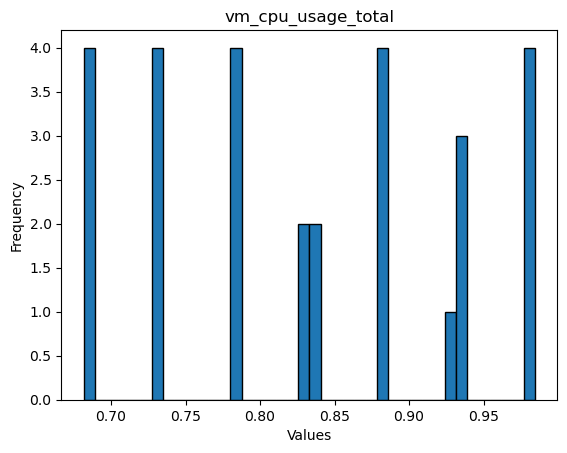

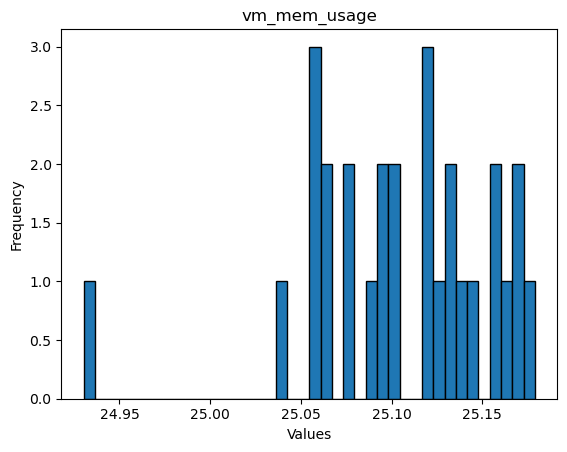

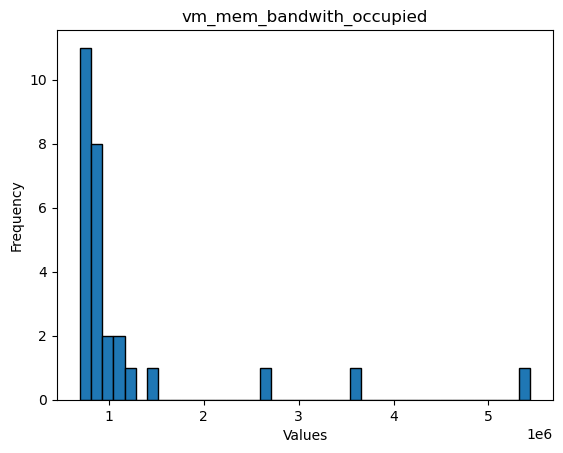

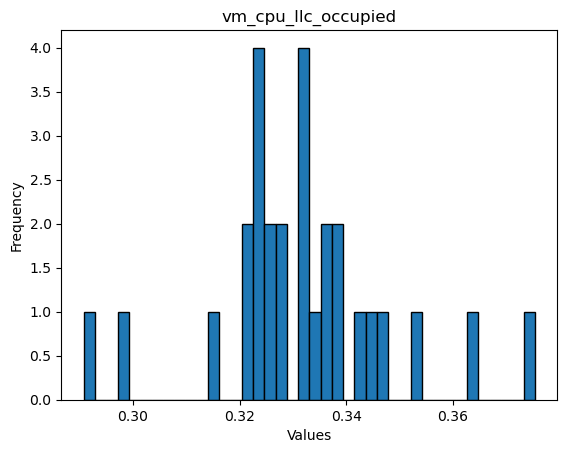

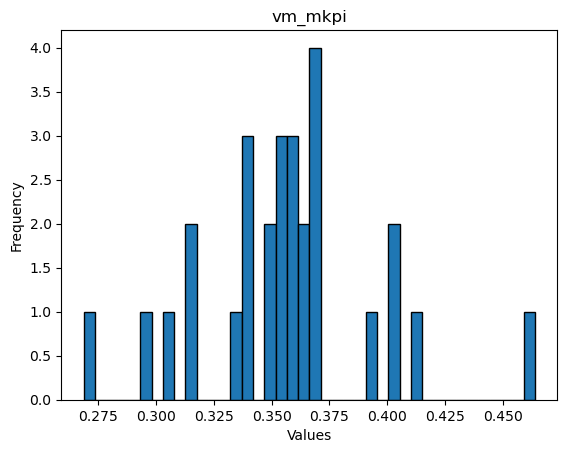

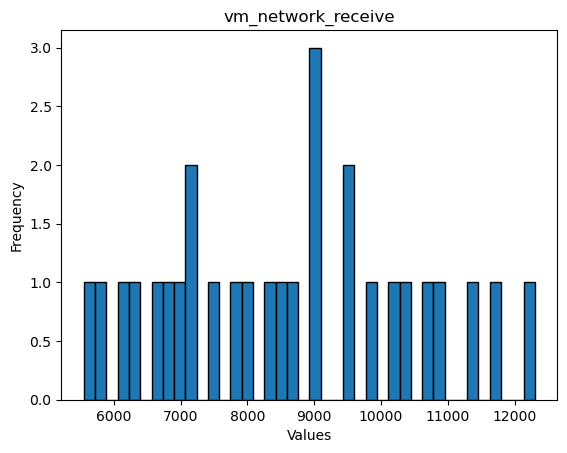

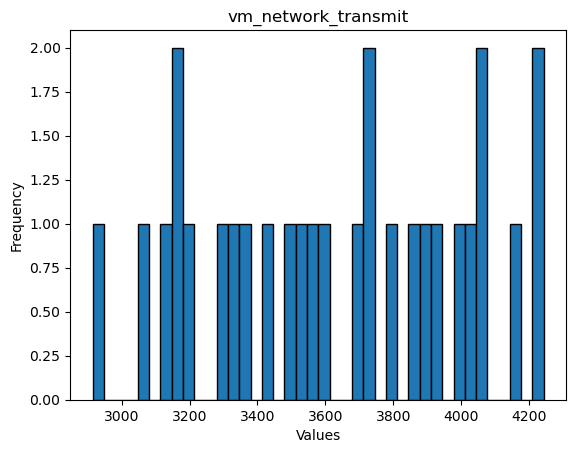

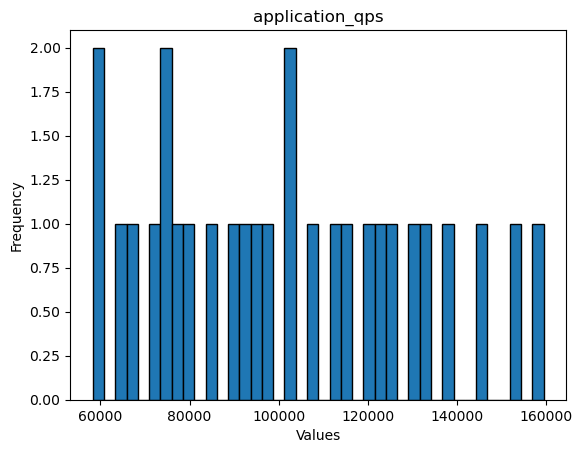

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# 选中的数据文件
TimeUnit = 's'
PICTURE_SIZE=(4,8)
Test_Count = "03"

def list_datas():
    all_files = os.listdir('data/bench_data{}'.format(Test_Count))
    csv_files = [file for file in all_files if file.endswith('.csv')]
    for file in csv_files:
        print(file)

def analysis_series_pre():
    all_files = os.listdir('data/bench_data{}'.format(Test_Count))
    csv_files = [file for file in all_files if file.endswith('.csv')]
    for file in csv_files:
        if "series" in file and ( 'exec002' in file or 'exec003' in file):
            data = pd.read_csv('data/bench_data{}/{}'.format(Test_Count,file)) 
            data['timestamp'] = data['timestamp'] + 8 * 3600
            data['relative_seconds'] = data['timestamp'] - data['timestamp'].min()
            fig, ax = plt.subplots(nrows=len(data.columns)-2, sharex=True, figsize=PICTURE_SIZE)  # 每个列都有一个子图，除了时间戳列
            axarr = ax if len(data.columns)-2 > 1 else [ax]
        
            for i, column in enumerate(data.columns[1:-1]):  # -1因为我们不绘制新添加的'relative_seconds'列
                axarr[i].plot(data['relative_seconds'], data[column], label=column)
                axarr[i].legend(loc='upper right')
                # axarr[i].set_ylabel(column)
            
            axarr[-1].set_xlabel('Relative Time (seconds)')

            fig.suptitle(file.rsplit('.', 1)[0])
            plt.tight_layout()
            plt.show()
            

def analysis_series_cdf():
    all_files = os.listdir('data/bench_data{}'.format(Test_Count))
    csv_files = [file for file in all_files if file.endswith('.csv')]

    
    for file in csv_files:
        if "series" in file:
            df = pd.read_csv('data/bench_data{}/{}'.format(Test_Count,file)) 
            # 遍历列，除了时间戳列
            df = df.iloc[100:]
            draw = False
            plt.figure(figsize=(16, 12))
            for column in df.columns[1:]:
                if df[column].isna().any():
                    print('exsit nan value file: {} column: {}'.format(file,column))
                    df[column] = df[column].fillna(df[column].median())
                values, base = np.histogram(df[column], bins=100, density=True)
                cumulative = np.cumsum(values) / sum(values)
                base = (base - np.min(base)) / (np.max(base) - np.min(base))
                # 画图
                plt.plot(cumulative, base[:-1], label=column)
                draw = True
            if draw:
                plt.legend(loc='upper left')
                plt.title('CDF (Cumulative Distribution Function)')
                plt.xlabel('Value')
                plt.ylabel('Cumulative Probability')
                plt.grid(True)
                # plt.show()
                plt.savefig("data/bench_analysis{}/{}-cdf.png".format(Test_Count,file))


# 去掉开始测试的数据点数
DorpPoint = 100
def analysis_series_avg():
    all_files = os.listdir('data/bench_data{}'.format(Test_Count))
    csv_files = [file for file in all_files if file.endswith('.csv')]
    
    dfs = []
    for file in csv_files:
        if "series" in file:
            df = pd.read_csv('data/bench_data{}/{}'.format(Test_Count,file)) 
            df = df.iloc[DorpPoint:]
            df = df.mean().to_frame().transpose() 
            df = df.drop(columns=['timestamp'])
            df['test_params'] = file.rsplit('.', 1)[0]
            dfs.append(df)
    result = pd.concat(dfs, axis=0).reset_index(drop=True)
    result = result.sort_values(by='test_params')
    result.to_csv('data/bench_analysis{}/series-avg.csv'.format(Test_Count), index=False)
            
  

def analysis_bucket_cdf():
    all_files = os.listdir('data/bench_data{}'.format(Test_Count))
    csv_files = [file for file in all_files if file.endswith('.csv')]

    csv_files = sorted(csv_files, key=lambda x: (len(x), x))
    dfs  = []
    for file in csv_files:
        if "bucket" in file and 'CPU' in file:
            df = pd.read_csv('data/bench_data{}/{}'.format(Test_Count,file)) 
            # 遍历列，除了时间戳列
            for column in df.columns[1:]:
                df = df[df['timebucket']<40000]
                df = df.rename(columns={
                    column: file.rsplit('.', 1)[0].rsplit('_', 1)[1]
                })
                dfs.append(df)
    merged_df = pd.concat(dfs, axis=1)
    merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]
    merged_df.to_csv('data/bench_analysis{}/bucket-cdf.csv'.format(Test_Count), index=False)
    y = merged_df.drop(columns=['timebucket'])

    plt.figure(figsize=(12, 12))
    plt.plot(merged_df['timebucket'],y,label=y.columns)

    plt.legend(loc='upper right')
    plt.title('{} CDF'.format('total'))
    plt.xlabel('Value')
    plt.ylabel('Cumulative Probability')
    plt.grid(True)
    plt.savefig("data/bench_analysis{}/p99-cdf.png".format(Test_Count))


def analysis_series_hist():
    all_files = os.listdir('data/bench_data{}'.format(Test_Count))
    csv_files = [file for file in all_files if file.endswith('.csv')]
    
    dfs = []
    for file in csv_files:
        if "series" in file:
            df = pd.read_csv('data/bench_data{}/{}'.format(Test_Count,file)) 
            df = df.iloc[DorpPoint:]
            df = df.mean().to_frame().transpose() 
            df = df.drop(columns=['timestamp'])
            df['test_params'] = file.rsplit('.', 1)[0]
            dfs.append(df)
    result = pd.concat(dfs, axis=0).reset_index(drop=True)
    result = result.sort_values(by='test_params')
    # print(result)
    for column in result.columns[:-1]:
        plt.hist(result[column], bins=40, edgecolor='black')  # 'Values' 是DataFrame的列名
        plt.xlabel('Values')
        plt.ylabel('Frequency')
        plt.title(column)
        plt.show()
    
            

if __name__ == "__main__":
    # list_datas()
    # analysis_series_pre()
    # analysis_series_avg()
    analysis_series_hist()
    # analysis_series_cdf()
    # analysis_bucket_cdf()


    
